In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt


# **Pair Trading**

. Generate two fake securities

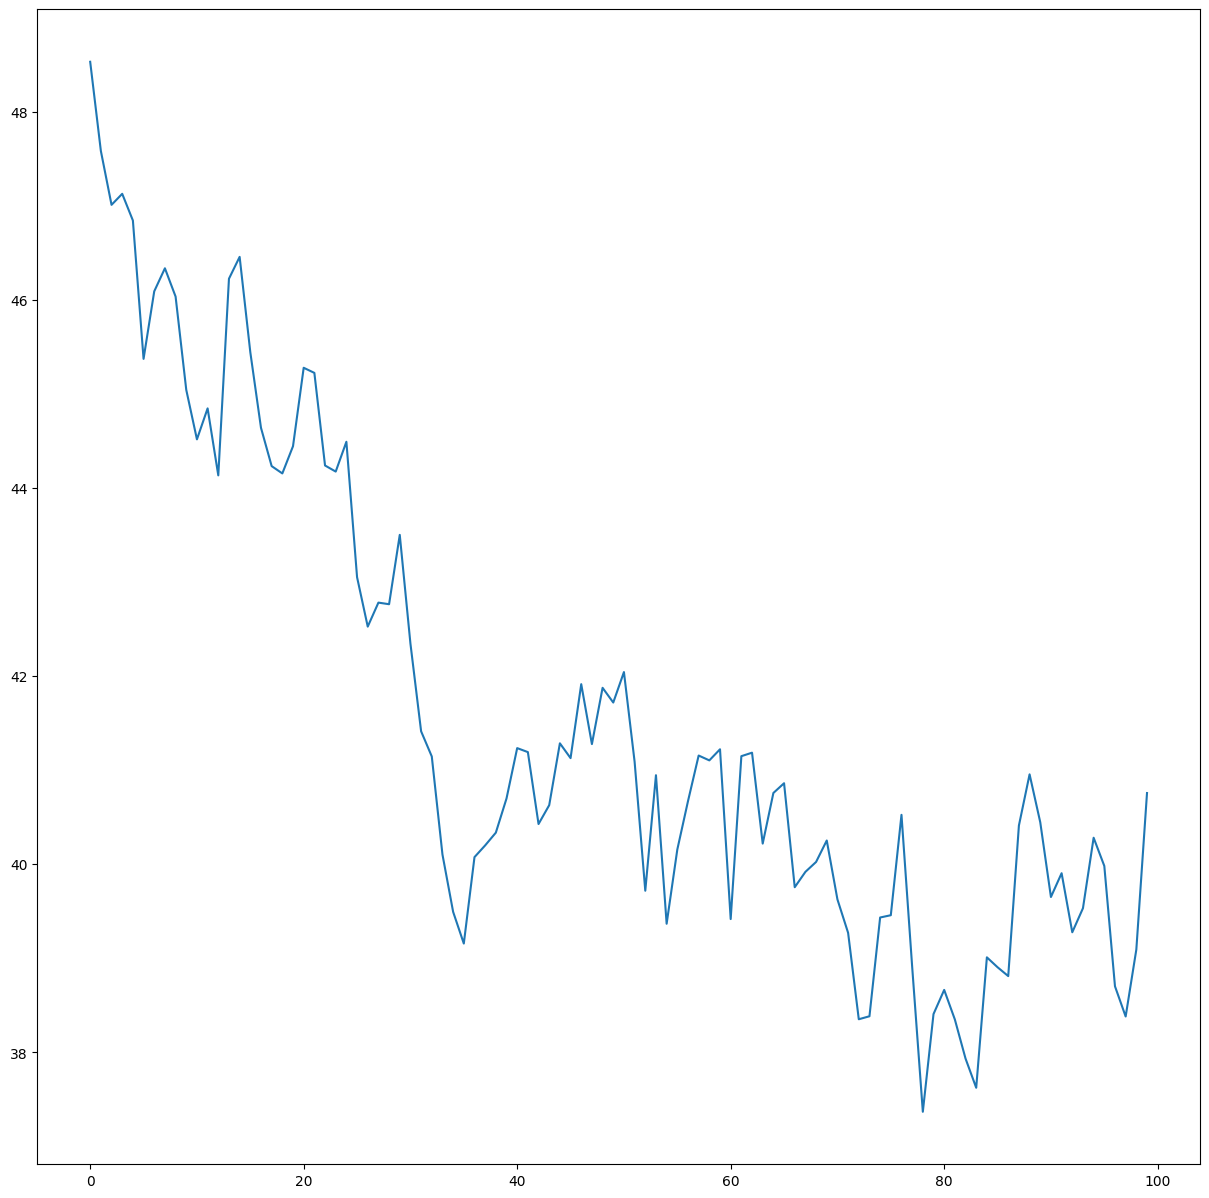

In [2]:
# Simulate the two fake securities by sampling from a normal distribution
# N.b: Sampling from a normal distribution is only for demo purposes and naturally it is too idealistic to model any real price moves

mu, sigma = 0, 1 # mean and standard deviation
X_returns = np.random.normal(mu, sigma, 100)

# sum up all the values from X_returns and shift it so that the output reflects ralistic price ranges
X = pd.Series(np.cumsum(X_returns), name='X') + 50
plt.figure(figsize=(15, 15))
X.plot();


Now we generate Y, i.e. the second simulated security. And the idea is that Y is meant to be highly correlated to X, that is their prices should be "similar" as time progresses.
To achieve this for purposes of this demo, we just shift X and add some noise that is drawn from a normal distribution

<Axes: >

<Figure size 1500x1500 with 0 Axes>

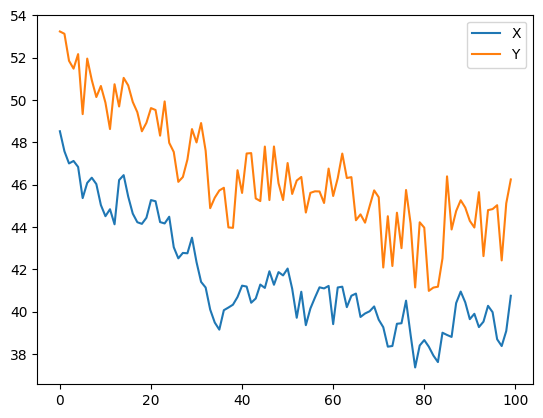

In [3]:
Noise = np.random.normal(0,1,100)
Y = X + 5 + Noise
Y.name = 'Y'
plt.figure(figsize=(15, 15))
pd.concat([X, Y], axis = 1).plot()

# **Co-Integration**

Note that two series are cointgerated when they share a common stochastic drift. More formally, if two or more series are individually integrated (i.e., they are non-stationary and can be made to be stationary by differencing) but some linear combination of them is stationary, then the series are said to be cointegrated. Essentially this means that even though they may wander off from each other in the short run, there is a tendency for them to converge to a long-run equilibrium relationship over time.


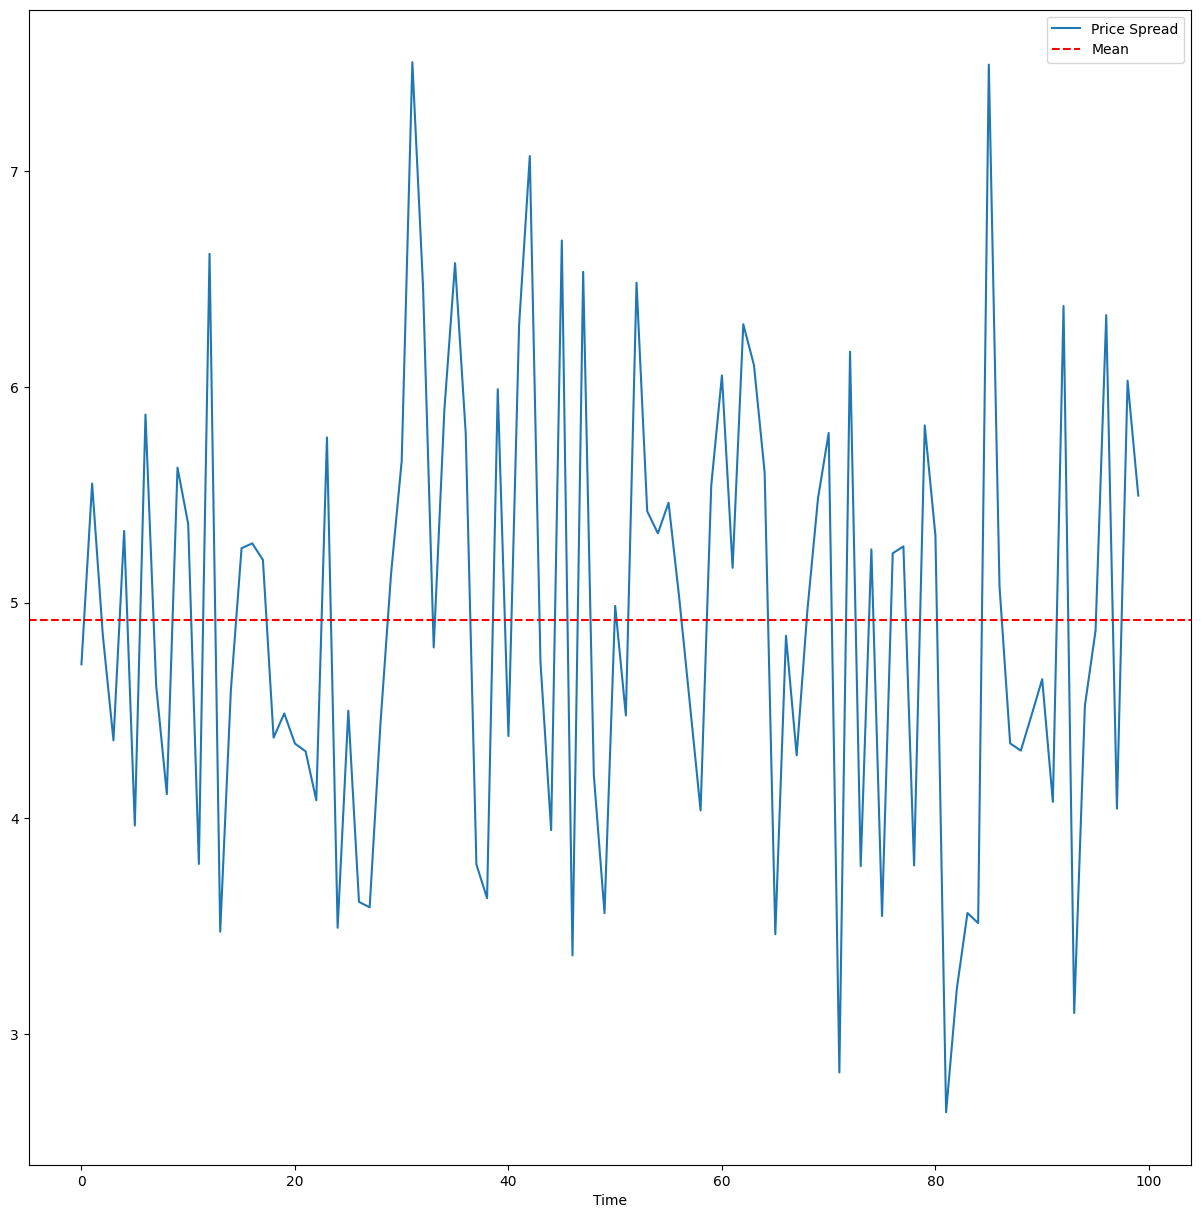

In [4]:
plt.figure(figsize=(15, 15))
(Y - X).plot() #plot the spread/difference
plt.axhline((Y-X).mean(), color='red', linestyle='--') #Adding the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

# **Testing for Cointegration**

To determine statistically if our two securities are actually cointegrated, we expect to see a very low p-value.

In [5]:
score, p_value, _ = coint(X,Y)

In [6]:
if p_value < 0.05:
  print(p_value, " thus X,Y are likely cointegrated")
else:
  print(p_value, " thus X,Y are likely not cointegrated")

1.0044946339030755e-05  thus X,Y are likely cointegrated


# **Correlation != Cointegration**

<Figure size 1500x1500 with 0 Axes>

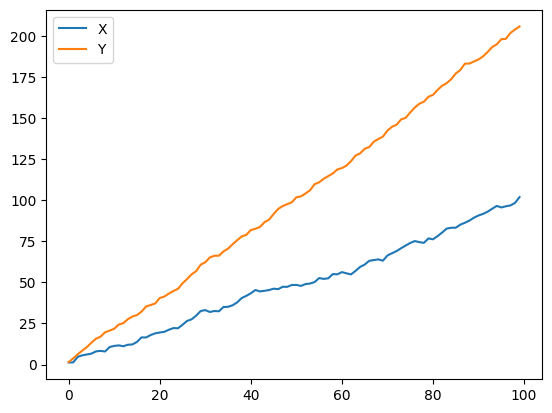

In [7]:
# Here is an example of two series that are highly correlated but not cointegrated
X_returns = np.random.normal(1,1,100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

plt.figure(figsize=(15, 15))
pd.concat([X_diverging, Y_diverging], axis=1).plot();

In [8]:
print('Correlation: ', str(X_diverging.corr(Y_diverging)))
score, p_value2, _ = coint(X_diverging, Y_diverging)
print('Cointegrations test p_value of X_diverging and y_diverging is: ', str(p_value2))

Correlation:  0.9978499777226268
Cointegrations test p_value of X_diverging and y_diverging is:  0.15748414445516895


In [9]:
# Now here is an example of two series that are cointegrated but not correlated
X2 = pd.Series(np.random.normal(0, 1, 1000), name='X2') + 20
X3 = X2.copy()
# X2 = X2 + 10
X3[0:100] = 30
X3[100:200] = 10
X3[200:300] = 30
X3[300:400] = 10
X3[400:500] = 30
X3[500:600] = 10
X3[600:700] = 30
X3[700:800] = 10
X3[800:900] = 30
X3[900:1000] = 10

(0.0, 40.0)

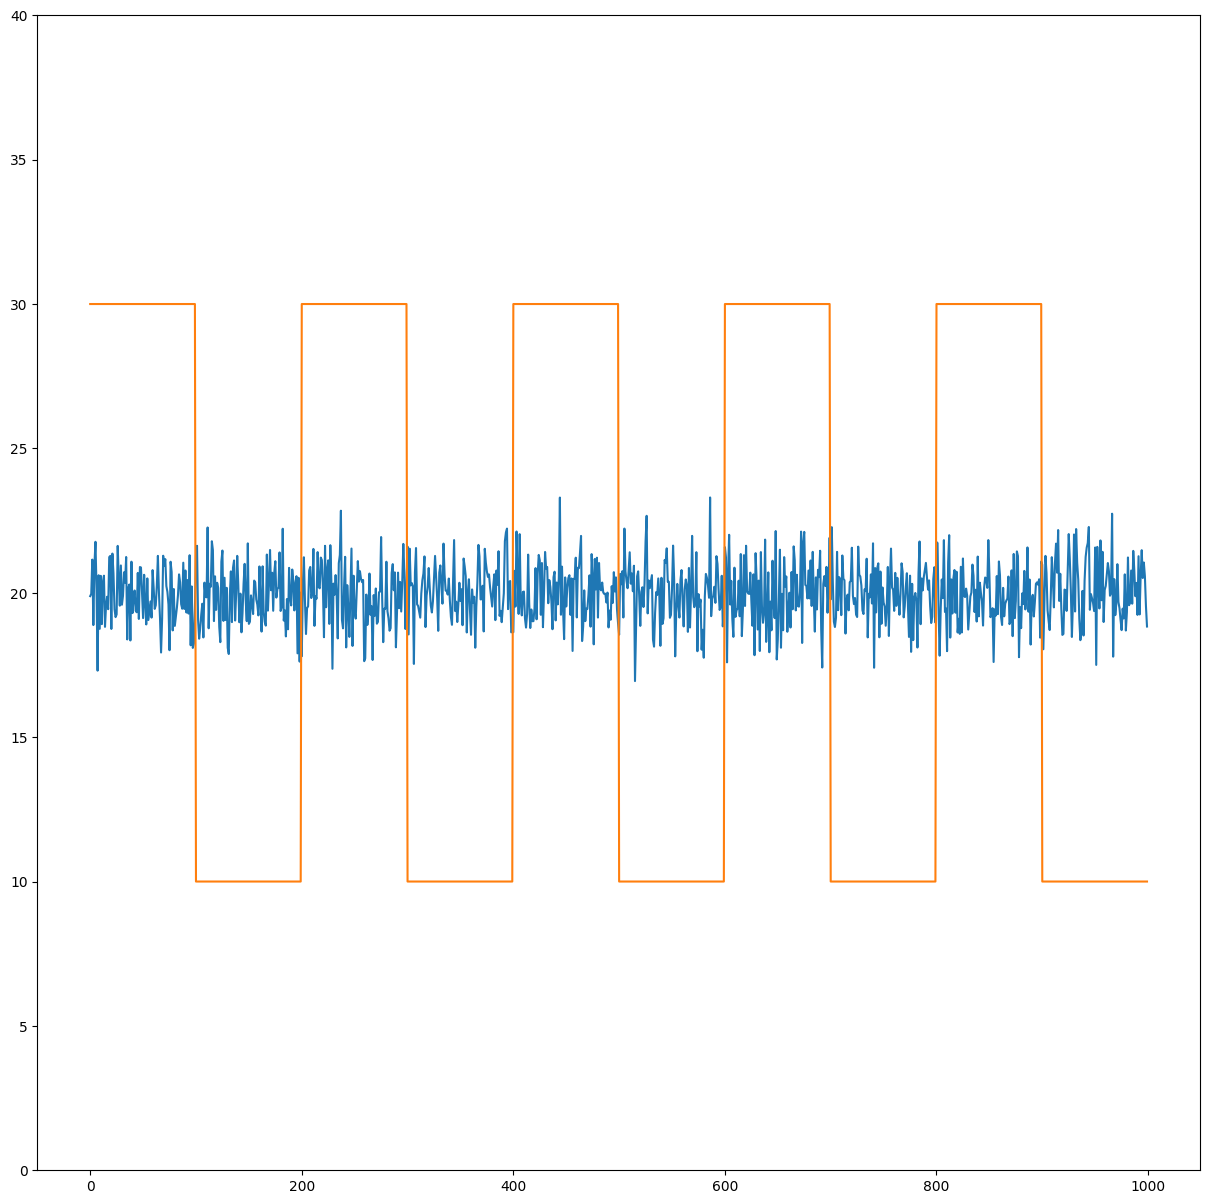

In [10]:
plt.figure(figsize=(15, 15))
X2.plot();
X3.plot();
plt.ylim([0,40])

In [11]:
print('Correlation: ', str(X2.corr(X3)))
score, p_value3, _ = coint(X2, X3)
print('Cointegrations test p_value of X_diverging and y_diverging is: ', str(p_value3))

Correlation:  -0.0413546225550515
Cointegrations test p_value of X_diverging and y_diverging is:  2.2900925088108862e-09


# **Hedged Position**


By Definition; this is a simple method to protect ones portfolio by making it immune to marker movements as much as possible.

The two main strategies are; 1. Long the Spread, 2. Short the Spread

**Warning**: The real life implementation of finding such co-integrated assets, we are wise to avoid a certain common pitfall; namely the ["Multiple Comparisons Bias"](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).


# Looking for Cointegrated Pairs of Alternative Energy Securities

Analyzing various solar company stocks to see if any such cointegration pairs are among the names.

In [12]:
def find_cointegrated_pairs(data):
  n = data.shape[1] #dim of the data
  score_matrix = np.zeros((n,n)) # init an nxn matrix which records the cointegration value of each pair; n^2 total values
  pvalue_matrix = np.zeros((n,n)) # init an nxn matrix to record the pvalues of each pair
  keys = data.keys() # the name of the securities
  pairs = []
  # get the cointegration values of each pair and populate the score and pvalue matrix respectively
  for i in range(n):
    for j in range(1+i, n):
      S1 = data[keys[i]]
      S2 = data[keys[j]]
      result = coint(S1, S2)
      score = result[0]
      pvalue = result[1]
      score_matrix[i,j] = score
      pvalue_matrix[i,j] = pvalue
      if pvalue < 0.05:
        pairs.append((keys[i], keys[j]))
  return score_matrix, pvalue_matrix, pairs


In [13]:
import yfinance as yf

In [14]:
symbol_list = ['ABG', 'HYSR', 'DQ', 'FSLR','SPY']
prices_df = yf.download(symbol_list, start='2014-01-01', end='2015-01-01')['Close']
prices_df.head()

[*********************100%***********************]  5 of 5 completed


,ABG,DQ,FSLR,HYSR,SPY
Date,,,,,
2014-01-02,53.980000,7.600,57.439999,0.006,182.919998
2014-01-03,53.029999,7.818,56.740002,0.006,182.889999
2014-01-06,52.709999,8.010,51.259998,0.006,182.360001
2014-01-07,52.810001,8.386,52.490002,0.006,183.479996
2014-01-08,52.090000,8.476,51.680000,0.007,183.520004


Now we'll run our method on the list and see if any pairs are cointegrated.

[('ABG', 'SPY')]


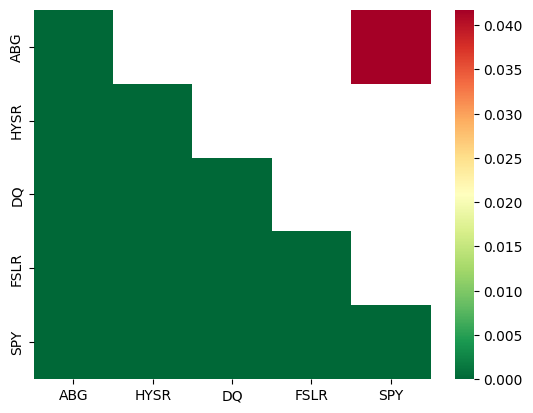

In [15]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [16]:
S1 = prices_df['ABG']
S2 = prices_df['SPY']
score, pvalue, _ = coint(S1, S2)
pvalue

0.04175197222729838

#Calculating the Spread

Now we will plot the spread of the two series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities. Using a linear regression to estimate the coefficient is known as the Engle-Granger method.

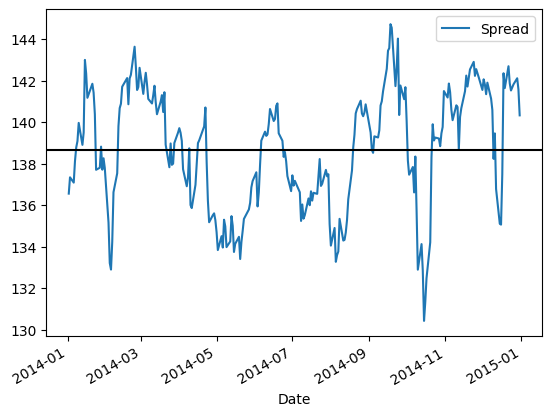

In [17]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ABG']
b = results.params['ABG']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

Alternatively, we could examine the ratio betwen the two series.

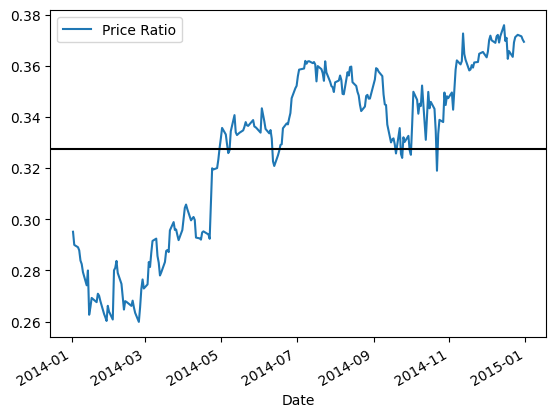

In [18]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score.

In [19]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

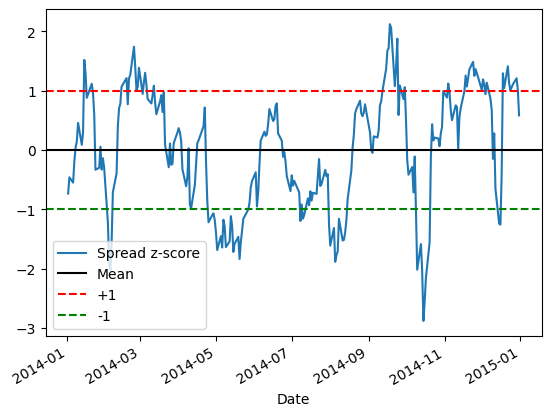

In [20]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

#Strategy



1.   Go Long on the Spread when the z-score is below -1.0
2.   Go Short on the Spread when the z-score is above 1.0
3.   Exit the positions when the z-score approaches 0



Warning: In general taking a statistic over your whole sample size can lead to false hypothesis. That is consider when the market is moving up, and both securities are also trending up, thus the average price of both securities over the last x years may not be representative of today. Hence its best to use statistics that rely on rolling windows, i.e. moving averages, of the most recent data.

#Moving Averages

By definition it is the average over the last
n datapoints for each given time, that is if we choose n=15, then we are taking the average of the last 15 timestamped prices. Which naturally implies the smaller n is, the more likely that the moving average will be less smooth and less reliable unlike one in which n is larger, however the smaller n is able to react to price changes much more quickly as opposed to when n is larger.

In [24]:
from statsmodels.regression.rolling import RollingOLS

In [31]:
!pip install pyfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.3 MB/s eta 0:00:00


In [32]:
from pyfinance.ols import PandasRollingOLS

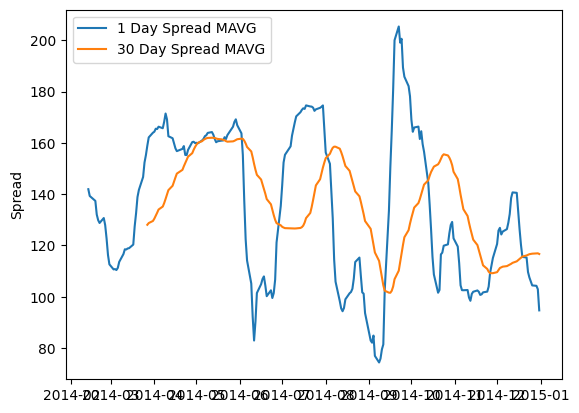

In [41]:
model = PandasRollingOLS(y=S2, x=S1, window=30)

spread = S2 - model.beta['feature1'] * S1
spread.name = 'spread'

spread_mavg1 = spread.rolling(1).mean()
spread_mavg1.name = 'spread 1day mavg'

spread_mavg30 = spread.rolling(30).mean()
spread_mavg30.name = 'spread 30day mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

We could in fact use the moving averages to compute the z-score of the spread at each given time. This will tell us how extreme the spread is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

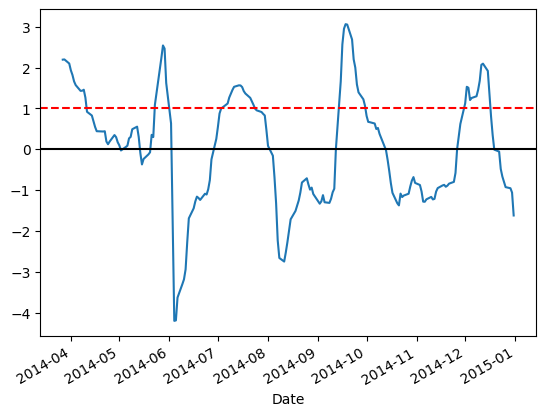

In [42]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the spreads were all negative and that is a little counterintuitive to trade on.

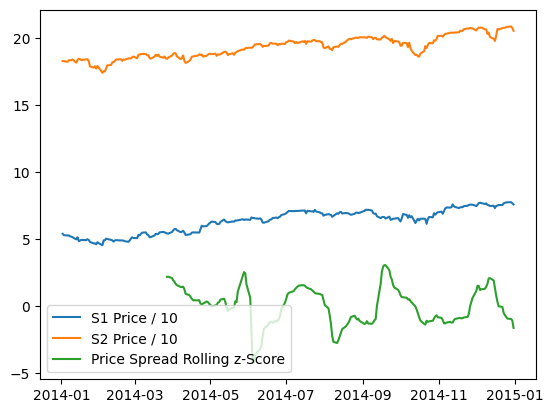

In [43]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);

#Out of Sample Test

Now that we have constructed our spread appropriately and have an idea of how we will go about making trades, it is time to conduct some out of sample testing. Our whole model is based on the premise that these securities are cointegrated, but we built it on information from a certain time period. If we actually want to implement this model, we need to conduct an out of sample test to confirm that the principles of our model are still valid going forward.

Since we initially built the model on the 2014 - 2015 year, let's see if this cointegrated relationship holds for 2015 - 2016. Historical results do not guarantee future results so this is a sanity check to see if the work we have done holds strong.


In [49]:
symbol_list = ['ABG', 'SPY']
prices_df = yf.download(symbol_list, start='2015-01-01', end='2016-01-01')['Close']
#prices_df.columns = map(lambda x: x.symbol, prices_df.columns)

S1 = prices_df['ABG']
S2 = prices_df['SPY']

score, pvalue, _ = coint(S1, S2)
print('p-value: ', pvalue)

[*********************100%***********************]  2 of 2 completed
p-value:  0.8946527274171103


Unfortunately, since our p-value is above the cutoff of
0.05
, we conclude that our model will no longer be valid due to the lack of cointegration between our chosen securities. If we tried to deploy this model without the underlying assumptions holding, we would have no reason to believe that it would actually work. Out of sample testing is a vital step to make sure that our work will actually be viable in the market.